
=== Dataset Split Check ===
Train: 31646 (70.00%)
Validation: 6783 (15.00%)
Test: 6782 (15.00%)



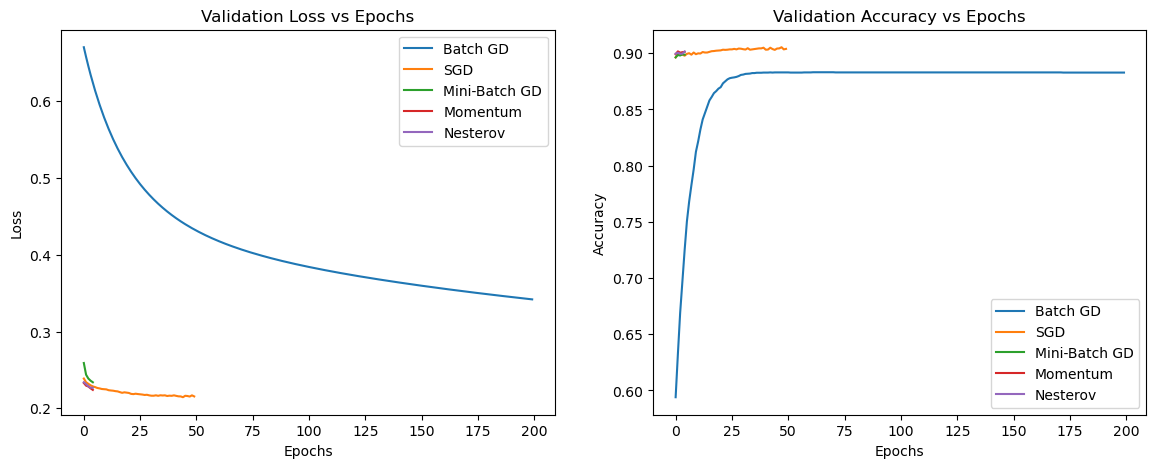

Mini-batch size 16: epochs=5, time=19.27s
Mini-batch size 32: epochs=5, time=11.55s
Mini-batch size 128: epochs=5, time=3.53s

SGD Learning Rate Sensitivity
LR=0.001, epochs=5
LR=0.01, epochs=5
LR=0.1, epochs=5

Momentum Sensitivity
Momentum=0.5, epochs=5
Momentum=0.9, epochs=5
Momentum=0.99, epochs=5
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step

Test Set Performance (Nesterov)
Accuracy : 0.8995871424358596
Precision: 0.6212121212121212
Recall   : 0.3619167717528373
F1-score : 0.45737051792828687
Confusion Matrix:
 [[5814  175]
 [ 506  287]]


In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
# 1. Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load & Preprocess Dataset
df = pd.read_csv(r"Z:\Applied AI\bank-full1.csv")  # update path if needed
df = df.replace("unknown", np.nan)

# Fill missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Encode target
df["y"] = df["y"].map({"yes": 1, "no": 0})

# One-hot encode categorical features
X = pd.get_dummies(df.drop("y", axis=1), drop_first=True)
y = df["y"]

# Standardize
scaler = StandardScaler()
X_processed = scaler.fit_transform(X)

# 3. Train / Validation / Test Split (70 / 15 / 15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.15, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=SEED, stratify=y_temp
)  # 0.1765 of 85% ≈ 15%

input_dim = X_train.shape[1]

print("\n=== Dataset Split Check ===")
total = len(X_processed)
print(f"Train: {len(X_train)} ({len(X_train)/total:.2%})")
print(f"Validation: {len(X_val)} ({len(X_val)/total:.2%})")
print(f"Test: {len(X_test)} ({len(X_test)/total:.2%})")

# 4. Model Builder (Fixed Architecture)
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# 5. Training Function
def train_experiment(optimizer, batch_size, lr, momentum=None, nesterov=False):
    tf.keras.backend.clear_session()
    model = build_model(X_train.shape[1])

    if momentum is None:
        opt = optimizer(learning_rate=lr)
    else:
        opt = optimizer(learning_rate=lr, momentum=momentum, nesterov=nesterov)

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=200,
        callbacks=[early_stopping],
        verbose=0
    )
    total_time = time.time() - start
    return model, history.history, total_time

# 6. Optimizer Experiments
experiments = {
    "Batch GD": lambda: train_experiment(tf.keras.optimizers.SGD, len(X_train), 0.01),
    "SGD": lambda: train_experiment(tf.keras.optimizers.SGD, 8, 0.01),
    "Mini-Batch GD": lambda: train_experiment(tf.keras.optimizers.SGD, 32, 0.01),
    "Momentum": lambda: train_experiment(tf.keras.optimizers.SGD, 32, 0.01, momentum=0.9),
    "Nesterov": lambda: train_experiment(tf.keras.optimizers.SGD, 32, 0.01, momentum=0.9, nesterov=True)
}

results = {}
for name, fn in experiments.items():
    model, history, t = fn()
    results[name] = {"model": model, "history": history, "time": t}
    
# 7. Comparative Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]["history"]["val_loss"], label=name)
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]["history"]["val_accuracy"], label=name)
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 8. Mini-Batch Size Study
batch_sizes = [16, 32, 128]
for bs in batch_sizes:
    _, h, t = train_experiment(tf.keras.optimizers.SGD, bs, 0.01)
    print(f"Mini-batch size {bs}: epochs={len(h['loss'])}, time={t:.2f}s")

# 9. Hyperparameter Sensitivity
print("\nSGD Learning Rate Sensitivity")
for lr in [0.001, 0.01, 0.1]:
    _, h, _ = train_experiment(tf.keras.optimizers.SGD, 32, lr)
    print(f"LR={lr}, epochs={len(h['loss'])}")

print("\nMomentum Sensitivity")
for m in [0.5, 0.9, 0.99]:
    _, h, _ = train_experiment(tf.keras.optimizers.SGD, 32, 0.01, momentum=m)
    print(f"Momentum={m}, epochs={len(h['loss'])}")

# 10. Test Set Evaluation (Best Optimizer: Nesterov)
best_model = results["Nesterov"]["model"]
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

print("\nTest Set Performance (Nesterov)")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
